# Active Model B+ Workbook

## 0. Preamble

In [8]:
import sys, os
import cloudpickle
from functools import cache

import numpy as np
from scipy import optimize
import sympy as sp
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from activemodelbplus import activedroplets
from activemodelbplus.activedroplets import ActiveModelBPlus
from activemodelbplus.activefield import symbols

## 1. Bulk binodals

We start with the bulk binodals for coexistence in active model B+. These are obtained by the simultaneously matching bulk free energies and pseudopressures, as described in Tjhung et al. (2018). We show the result of this below that agrees with Fig. 2 of Tjhung et al. (2018), though I haven't bothered with a direct comparison as this is a less stringent tests in the next section for spherical droplets (that have good agreement).

Note: in all calculations we take the passive parameters in active model B+ as $-a = b = 0.25$ and $K = 1$.

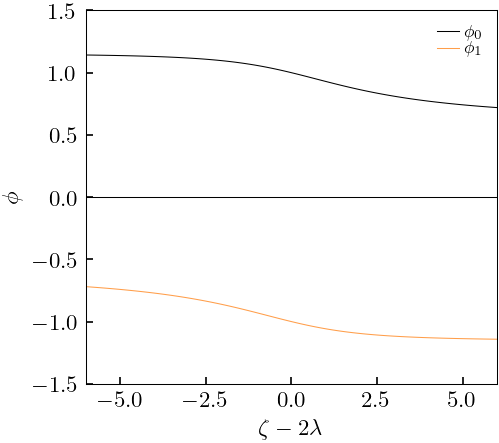

In [9]:
zeta_lamb = np.linspace(-6, 6, 101) # (zeta - 2*lambda) parameter
phi0, phi1 = activedroplets.binodal_densities(zeta_lamb)

plt.plot(zeta_lamb, phi0, label=r'$\phi_0$')
plt.plot(zeta_lamb, phi1, label=r'$\phi_1$')
plt.axhline(y=0, lw=0.5)
plt.xlim([-6, 6])
plt.ylim([-1.5, 1.5])
plt.xlabel(r'$\zeta - 2\lambda$')
plt.ylabel(r'$\phi$')
plt.legend(loc='best');

We could also look at the density profiles along planar interfaces at each state point via:

<ActiveBinodal zeta=-2 lamb=0 phi=[1.0954->-0.8636] nnodes=101>
<ActiveBinodal zeta=-1 lamb=0 phi=[1.0578->-0.9297] nnodes=101>
<ActiveBinodal zeta=0 lamb=0 phi=[0.9999->-0.9999] nnodes=101>
<ActiveBinodal zeta=1 lamb=0 phi=[0.9297->-1.0578] nnodes=101>
<ActiveBinodal zeta=2 lamb=0 phi=[0.8636->-1.0954] nnodes=101>


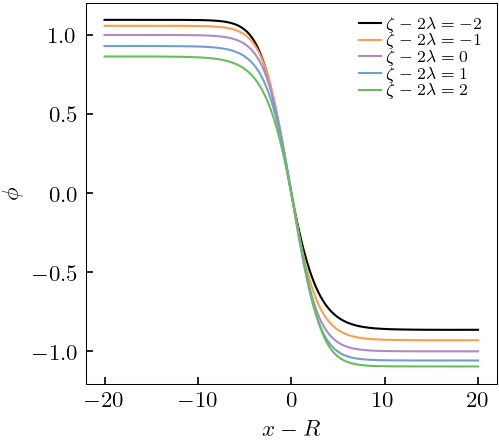

In [11]:
x = np.linspace(-20, 20, 1000)

@cache
def binodal(zeta_lamb):
    zeta = zeta_lamb
    lamb = 0
    field = activedroplets.ActiveModelBPlus(zeta, lamb)
    return field.binodal()

for zeta_lamb in np.linspace(-2, 2, 5):
    b = binodal(zeta_lamb)
    print(b)

    label = r'$\zeta - 2\lambda = %g$' % zeta_lamb
    plt.plot(x, b(x), lw=1, label=label)

plt.xlabel('$x-R$')
plt.ylabel(r'$\phi$')
plt.legend(loc='best');
plt.savefig('binodal_profiles.pdf')
plt.savefig('binodal_profiles.png')

NB: above we set $\lambda = 0$ in the calculation stage for convenience, as only $\zeta - 2\lambda$ matters for planar interfaces.

The functional form of the kink is
\begin{equation}
  z - z_0 = \pm \int_{\psi_0}^\psi  \frac{d\psi}{\sqrt{-\frac{2}{K} (1 + \alpha \psi) \Delta P}}
\end{equation}
where $\Delta P = P - P_0$ with $P = \psi \mu - g$ and $\alpha = (\zeta - 2\lambda) / K$.

Below I attempt to find the interface profile by this method - it doesn't go quite right so it's a work in progress.

<lambdifygenerated-1664>:2: RuntimeWarning: invalid value encountered in power
  return ((-4.0*psi - 2.0)*(-0.0625*psi**4 + 0.125*psi**2 + psi*(0.25*psi**3 - 0.25*psi) - 4.6913649427321))**(-0.5)


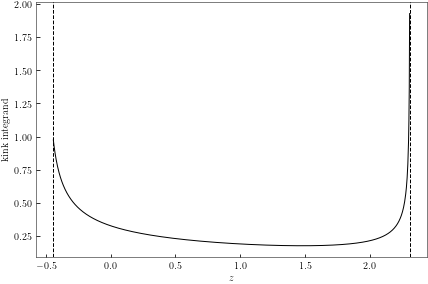

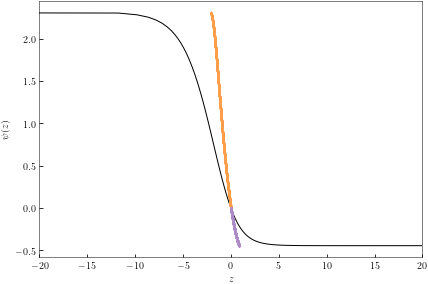

In [ ]:
b = binodal(2)

field = b.field_theory
zeta = field.zeta
lamb = field.lamb
zeta_lamb = zeta - 2*lamb
K = field.K
t = field.t
u = field.u
psi = sp.symbols('psi')

g = t/2 * psi**2 + u/4 * psi**4
alpha = zeta_lamb / K

mu = g.diff(psi)
p = mu*psi - g

phi0, phi1 = b.phi0, b.phi1
psi0, psi1 = b.pseudodensity(phi0), b.pseudodensity(phi1)
p0 = p.subs(psi,psi0)

# Kink solution
integrand = 1/(-2/K * (1 + alpha*psi) * (p-p0))**(1/2)
f = sp.lambdify(psi, integrand)

pp = np.linspace(psi0, psi1, 1000)
plt.plot(pp, f(pp))
plt.axvline(x=psi0, ls='dashed')
plt.axvline(x=psi1, ls='dashed')
plt.xlabel('$z$')
plt.ylabel('kink integrand')

from scipy.integrate import cumtrapz
phi = b(b.x)
pp = b.pseudodensity(phi)
psi_middle = b.pseudodensity(0)

plt.figure()
plt.plot(b.x, pp)
for psi_end in [psi0, psi1]:
    pp2 = np.linspace(psi_middle, psi_end, 1000)
    z = -4*cumtrapz(f(pp2), pp2, initial=0)
    plt.plot(z, pp2, '.')

plt.xlabel('$z$')
plt.ylabel('$\psi(z)$')
plt.xlim([-20, 20]);

## 2. Coexisting densities vs droplet size

Tjhung et al. (2018) take as example the two state-points $(\zeta, \lambda) = (-1, 0.5)$ and $(-4, -1)$ because these have the same value of $\zeta - 2\lambda = -2$ (so they have the same bulk density profile) yet they have different surface tensions. Specifically, in their calculations the former has positive (i.e. normal) surface tension whereas the latter has negative surface tension and thus reverse Ostwald ripening is expected.

Below we find the steady-state droplet profiles corresponding to these two state-points with varying droplet radius $R$, and compare the resulting coexisting densities against the results of Tjhung et al. (2018). The densities at $r = 0$ and $r \to \infty$ are allowed to vary while keeping $\phi(r=R) = 0$. This can be inverted to obtain $R$ as a function of $\lim_{r\to\infty} \phi(r)$.

In [ ]:
R = np.arange(10, 101, 1)

@cache
def droplets(zeta, lamb, d):
    cache_path = 'zeta=%g_lamb=%g_d=%d.drops' % (zeta, lamb, d)
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            drops = cloudpickle.load(f)

    else:
        model = ActiveModelBPlus(zeta, lamb, d=d)
        drops = []
        for r in R:
            try: drops += [model.droplet(r)]
            except:
                # Sometimes the Newton method fails to converge, but this can
                # be fixed by providing the last droplet as an initial guess.
                drops += [model.droplet(r, guess=drops[-1])]
            print(drops[-1])

        with open(cache_path, 'wb') as f:
            cloudpickle.dump(drops, f)

    return drops

for d in [2, 3]:
    for zeta, lamb in [[-1, 0.5], [-4, -1]]:
        drops = droplets(zeta, lamb, d)

        # Pick the smallest droplet and show its profile for illustrative purposes.
        drop = drops[0]
        r = np.linspace(0, drop.x[-1], 1000)
        label = r'$\zeta=%g \; \lambda=%g \; d=%d$' % (zeta, lamb, d)
        plt.plot(r, drop(r), lw=0.5, label=label)

plt.xlabel('$r$')
plt.ylabel(r'$\phi$')
plt.legend(loc='best');

<>:37: SyntaxWarning: invalid escape sequence '\p'
<>:37: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_109957/3405397242.py:37: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('$\phi$')
caching call to ActiveBinodal.guess_profile_function with arguments: ((<class 'activemodelbplus.activedroplets.ActiveDroplet'>, 0), ())
caching call to ActiveBinodal.guess_profile_function with arguments: ((<class 'activemodelbplus.activedroplets.ActiveDroplet'>, 1), ())
caching call to ActiveBinodal.guess_profile_function with arguments: ((<class 'activemodelbplus.activedroplets.ActiveDroplet'>, 2), ())
caching call to ActiveBinodal.guess_profile_function with arguments: ((<class 'activemodelbplus.activedroplets.ActiveDroplet'>, 3), ())
ActiveModelBSphericalInterface: compiling main residuals... done.
caching call to WeakFormProblem1d.compiled_elemental_residuals with arguments: ((<class 'activemodelbplus.activefield.ActiveModelBSphericalInterface'>, 4), ())
ActiveModelBSpherical

<ActiveDroplet zeta=-1 lamb=0.5 d=2 R=10 nnodes=101>
<ActiveDroplet zeta=-1 lamb=0.5 d=2 R=11 nnodes=101>
<ActiveDroplet zeta=-1 lamb=0.5 d=2 R=12 nnodes=101>
<ActiveDroplet zeta=-1 lamb=0.5 d=2 R=13 nnodes=101>
<ActiveDroplet zeta=-1 lamb=0.5 d=2 R=14 nnodes=101>
<ActiveDroplet zeta=-1 lamb=0.5 d=2 R=15 nnodes=101>
<ActiveDroplet zeta=-1 lamb=0.5 d=2 R=16 nnodes=101>
<ActiveDroplet zeta=-1 lamb=0.5 d=2 R=17 nnodes=101>
<ActiveDroplet zeta=-1 lamb=0.5 d=2 R=18 nnodes=101>
<ActiveDroplet zeta=-1 lamb=0.5 d=2 R=19 nnodes=101>
<ActiveDroplet zeta=-1 lamb=0.5 d=2 R=20 nnodes=101>
<ActiveDroplet zeta=-1 lamb=0.5 d=2 R=21 nnodes=101>
<ActiveDroplet zeta=-1 lamb=0.5 d=2 R=22 nnodes=101>
<ActiveDroplet zeta=-1 lamb=0.5 d=2 R=23 nnodes=101>
<ActiveDroplet zeta=-1 lamb=0.5 d=2 R=24 nnodes=101>
<ActiveDroplet zeta=-1 lamb=0.5 d=2 R=25 nnodes=101>
<ActiveDroplet zeta=-1 lamb=0.5 d=2 R=26 nnodes=101>
<ActiveDroplet zeta=-1 lamb=0.5 d=2 R=27 nnodes=101>
<ActiveDroplet zeta=-1 lamb=0.5 d=2 R=28 nnode

Now we have the droplets at varying radius, we show the resulting coexisting densities for each $R$. These compare favourably with the values obtained by Tjhung et al. (2018) (dashed lines), especially considering we have used a different technique to obtain the droplet properties. The dotted horizontal lines are the bulk binodals for reference.

Incidentally, these plots would have to be inverted to obtain $R$ as a function of $\phi_1$ (because normally we'd be setting the background density as a control variable).

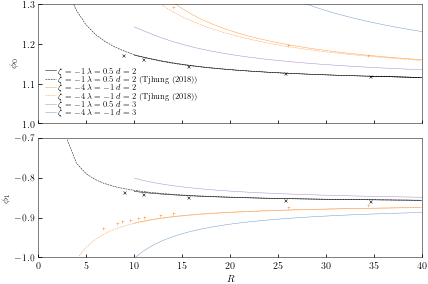

In [ ]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)

ax0.set_ylabel('$\phi_0$')
ax1.set_ylabel('$\phi_1$')
ax1.set_xlabel('$R$')

for d in [2, 3]:
    for zeta, lamb, marker in [[-1, 0.5, 'x'], [-4, -1, '+']]:
        phi1, phi0 = activedroplets.binodal_densities(zeta - 2*lamb)
        ax0.axhline(y=phi0, ls='dotted', lw=0.5, zorder=-10)
        ax1.axhline(y=phi1, ls='dotted', lw=0.5, zorder=-10)

        drops = droplets(zeta, lamb, d)
        phi0, phi1 = zip(*[(drop.phi0, drop.phi1) for drop in drops])

        label = r'$\zeta=%g \; \lambda=%g \; d=%d$' % (zeta, lamb, d)
        pl0, = ax0.plot(R, phi0, lw=0.5, label=label)
        pl1, = ax1.plot(R, phi1, lw=0.5, label=label)

        literature_dataset = 'tjhung2018_zeta=%g_lamb=%g_d=%d' % (zeta, lamb, d)
        label = '%s (Tjhung (2018))' % label
        try:
            lit_R, lit_phi0 = np.genfromtxt('%s_phi0.csv' % literature_dataset).T
            ax0.plot(lit_R, lit_phi0, '--', lw=0.5, c=pl0.get_color(), label=label)
            lit_R, lit_phi0 = np.genfromtxt('%s_phi0_sim.csv' % literature_dataset).T
            ax0.plot(lit_R, lit_phi0, marker, c=pl0.get_color())
        except: pass
        try:
            lit_R, lit_phi1 = np.genfromtxt('%s_phi1.csv' % literature_dataset).T
            ax1.plot(lit_R, lit_phi1, '--', lw=0.5, c=pl1.get_color(), label=label)
            lit_R, lit_phi1 = np.genfromtxt('%s_phi1_sim.csv' % literature_dataset).T
            ax1.plot(lit_R, lit_phi1, marker, c=pl1.get_color())
        except: pass

ax0.set_xlim([0, 40])
ax0.set_ylim([1,1.3])
ax1.set_ylim([-1,-0.7])
ax0.legend(loc='best');

Tjhung et al. (2018) argue that $\phi_1$ increasing with $R$ for $(\zeta, \lambda) = (-4, -1)$ is due to a negative surface tension. 
We verify that this is indeed negative below by taking the largest droplets calculated so far ($R=100$). We evaluate the pressure drop directly and via the surface tension route:

In [ ]:
for d in [2, 3]:
    for zeta, lamb in [[-1, 0.5], [-4, -1]]:
        drop = droplets(zeta, lamb, d)[-1]

        P0 = drop.pseudopressure0
        P1 = drop.pseudopressure1
        dP_true = P0-P1
        dP_surface_tension = drop.surface_tension_pseudopressure_drop
        print('zeta=%g lamb=%g d=%d:\tdP_true=%.4g dP_surface_tension=%.4g' %
              (zeta, lamb, d, dP_true, dP_surface_tension))

zeta=-1 lamb=0.5 d=2:	dP_true=0.002467 dP_surface_tension=0.002468
zeta=-4 lamb=-1 d=2:	dP_true=-0.003698 dP_surface_tension=-0.003697
zeta=-1 lamb=0.5 d=3:	dP_true=0.004926 dP_surface_tension=0.004927
zeta=-4 lamb=-1 d=3:	dP_true=-0.007761 dP_surface_tension=-0.00776


In [ ]:
for d in [2, 3]:
    zeta = 0
    for lamb in [-2, -1, 0, 1, 2]:
        drop = droplets(zeta, lamb, d)[-1]

        P0 = drop.pseudopressure0
        P1 = drop.pseudopressure1
        dP_true = P0-P1
        dP_surface_tension = drop.surface_tension_pseudopressure_drop
        print('zeta=%g lamb=%g d=%d:\tdP_true=%.4g dP_surface_tension=%.4g' %
              (zeta, lamb, d, dP_true, dP_surface_tension))

zeta=0 lamb=-2 d=2:	dP_true=0.005158 dP_surface_tension=0.005161
zeta=0 lamb=-1 d=2:	dP_true=0.004626 dP_surface_tension=0.004628
zeta=0 lamb=0 d=2:	dP_true=0.004713 dP_surface_tension=0.004714
zeta=0 lamb=1 d=2:	dP_true=0.004409 dP_surface_tension=0.00441
zeta=0 lamb=2 d=2:	dP_true=0.004731 dP_surface_tension=0.004732
zeta=0 lamb=-2 d=3:	dP_true=0.01054 dP_surface_tension=0.01055
zeta=0 lamb=-1 d=3:	dP_true=0.009381 dP_surface_tension=0.009383
zeta=0 lamb=0 d=3:	dP_true=0.009423 dP_surface_tension=0.009424
zeta=0 lamb=1 d=3:	dP_true=0.008695 dP_surface_tension=0.008696
zeta=0 lamb=2 d=3:	dP_true=0.009263 dP_surface_tension=0.009264


## 3. Surface tension

Here we look at variation of surface tension. We can do this by fixing $\zeta - 2\lambda$, so that we consider planar interfaces with the same density profile, and vary one parameter to see the variation of the surface tension.

Below we test this by taking $\zeta - 2 \lambda \in \{0, -2\}$.

Curiously, the surface tension appears to vary linearly with $\lambda$ in the tested range. Update: this is linear and not surprising (see supplementary pdf notes).

In [ ]:
@cache
def planar_profile(zeta_lamb):
    model = activedroplets.ActiveModelBPlus(zeta_lamb, 0, d=3)
    return model.binodal()

@cache
def surface_tension(zeta, lamb):
    profile = planar_profile(zeta - 2*lamb)
    model = activedroplets.ActiveModelBPlus(zeta, lamb, d=3)
    profile.field_theory = model
    return profile.surface_tension

In [ ]:
# for zeta_lamb in [0, -2]:
#     s = []
#     zeta = np.arange(-40, 41, 1)
#     lamb = 0.5*(zeta - zeta_lamb)
#     for z,l in zip(zeta, lamb):
#         s += [surface_tension(z, l)]

#     s0, s1 = zip(*s)
#     label = r'$\zeta - 2\lambda = %g$' % zeta_lamb
#     pl, = plt.plot(lamb, s0, lw=0.5, label=('%s (Josh)' % label))
#     plt.plot(lamb, s1, '--', lw=0.5, c=pl.get_color(), label=('%s (Tjhung)' % label))

# plt.ylim([-5, 5])
# plt.axhline(y=0, ls='dotted', lw=0.5, zorder=-10)
# plt.xlabel('$\lambda$')
# plt.ylabel('$\sigma$')
# plt.legend(loc='best');

Negative pseudotension corresponds to reverse Ostwald ripening, so now we vary $\zeta$ and $\lambda$ to find the boundary of vanishing pseudotension.

In [ ]:
def surface_tension_model(lamb, zeta_lamb):
    zeta = zeta_lamb + 2*lamb
    profile = planar_profile(zeta_lamb)
    model = activedroplets.ActiveModelBPlus(zeta, lamb)
    profile.field_theory = model
    return profile

def surface_tension2(lamb, zeta_lamb):
    return surface_tension_model(lamb, zeta_lamb).surface_tension

The calculation for the surface tension compares favourably with Tjhung et al's data (Fig 4. in their paper). The boundary shown marks where cluster droplets (positive $\phi$) become stabilised by reversed Ostwald ripening:  

In [6]:
l2 = []
zeta_lamb2 = np.linspace(-4, 4, 21)
for zl in zeta_lamb2:
    l2 += [optimize.newton_krylov(lambda l: surface_tension2(l, zl), 0)]

l2 = np.array(l2)
z2 = zeta_lamb2 + 2*l2
print(np.array((z2, l2)).T)

[[-4.03107242 -0.01553621]
 [-3.64834135 -0.02417067]
 [-3.2738645  -0.03693225]
 [-2.91068557 -0.05534278]
 [-2.56244058 -0.08122029]
 [-2.23320821 -0.1166041 ]
 [-1.92721834 -0.16360917]
 [-1.6484333  -0.22421665]
 [-1.4000306  -0.3000153 ]
 [-1.18387165 -0.39193582]
 [-1.00009977 -0.50004988]
 [-0.84704934 -0.62352467]
 [-0.72156891 -0.76078446]
 [-0.6196614  -0.9098307 ]
 [-0.53717212 -1.06858606]
 [-0.47028591 -1.23514295]
 [-0.41576779 -1.4078839 ]
 [-0.37100038 -1.58550019]
 [-0.33393445 -1.76696723]
 [-0.30297202 -1.95148601]
 [-0.27687089 -2.13843545]]


Check calculation matches the results of Tjhung (2018) (lines should overlap in the following):

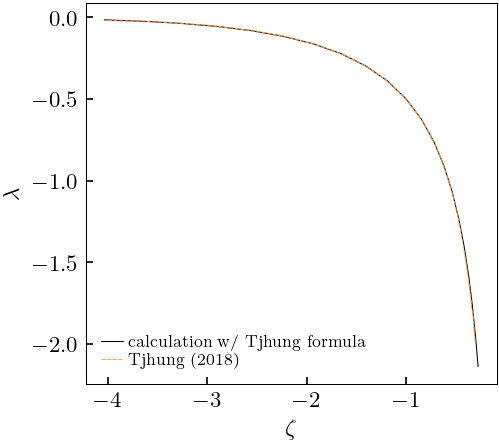

In [12]:
#plt.plot(z1, l1, lw=0.5, label='Josh')
plt.plot(z2, l2, '-', lw=0.5, label='calculation w/ Tjhung formula')

lit_z, lit_l = np.genfromtxt('tjhung2018_reversal_clusters.csv').T
plt.plot(lit_z, lit_l, '--', lw=0.5, label='Tjhung (2018)')

plt.xlabel(r'$\zeta$')
plt.ylabel(r'$\lambda$')
plt.legend(loc='best');

Make a nice phase diagram for reversal of Ostwald ripening:

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_111218/1006090377.py:7: SyntaxWarning: invalid escape sequence '\s'
  plt.text(-2,  1, 'Forward Ostwald\nripening\n($\sigma > 0$)', fontsize=fontsize, ha='center', va='center')
/tmp/ipykernel_111218/1006090377.py:8: SyntaxWarning: invalid escape sequence '\s'
  plt.text( 2.25,  1.5, 'Reverse Ostwald\nripening for bubbles\n($\sigma < 0$)', fontsize=fontsize, ha='center', va='center')
/tmp/ipykernel_111218/1006090377.py:9: SyntaxWarning: invalid escape sequence '\s'
  plt.text(-2.25, -1.5, 'Reverse Ostwald\nripening for clusters\n($\sigma < 0$)', fontsize=fontsize, ha='center', va='center')


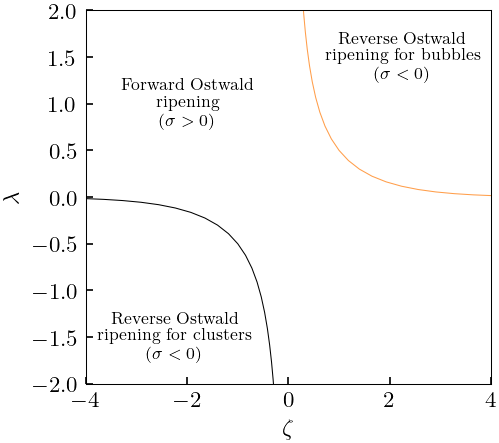

In [46]:

plt.plot(z2, l2, '-', lw=0.5)
plt.plot(-z2, -l2, '-', lw=0.5)
plt.xlim([-4, 4])
plt.ylim([-2, 2])

fontsize = 8
plt.text(-2,  1, 'Forward Ostwald\nripening\n($\sigma > 0$)', fontsize=fontsize, ha='center', va='center')
plt.text( 2.25,  1.5, 'Reverse Ostwald\nripening for bubbles\n($\sigma < 0$)', fontsize=fontsize, ha='center', va='center')
plt.text(-2.25, -1.5, 'Reverse Ostwald\nripening for clusters\n($\sigma < 0$)', fontsize=fontsize, ha='center', va='center')

plt.xlabel(r'$\zeta$')
plt.ylabel(r'$\lambda$')

plt.show()